# Spaceship Titanic Dataset with TensorFlow Decision Forests

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Exploration

In [2]:
dataset = pd.read_csv('train.csv')
dataset.describe()
dataset.info()
dataset.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


<Axes: >

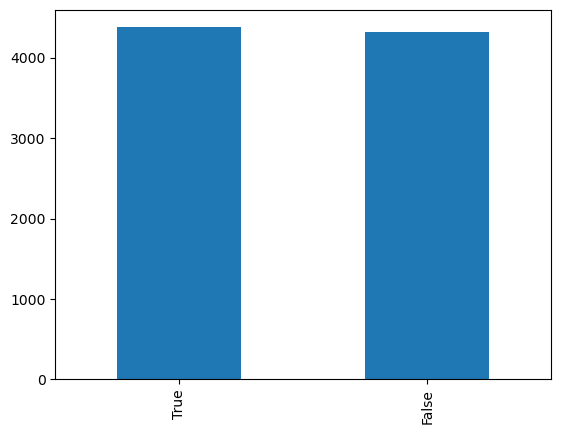

In [3]:
plot_df = dataset.Transported.value_counts()
plot_df.plot(kind='bar')

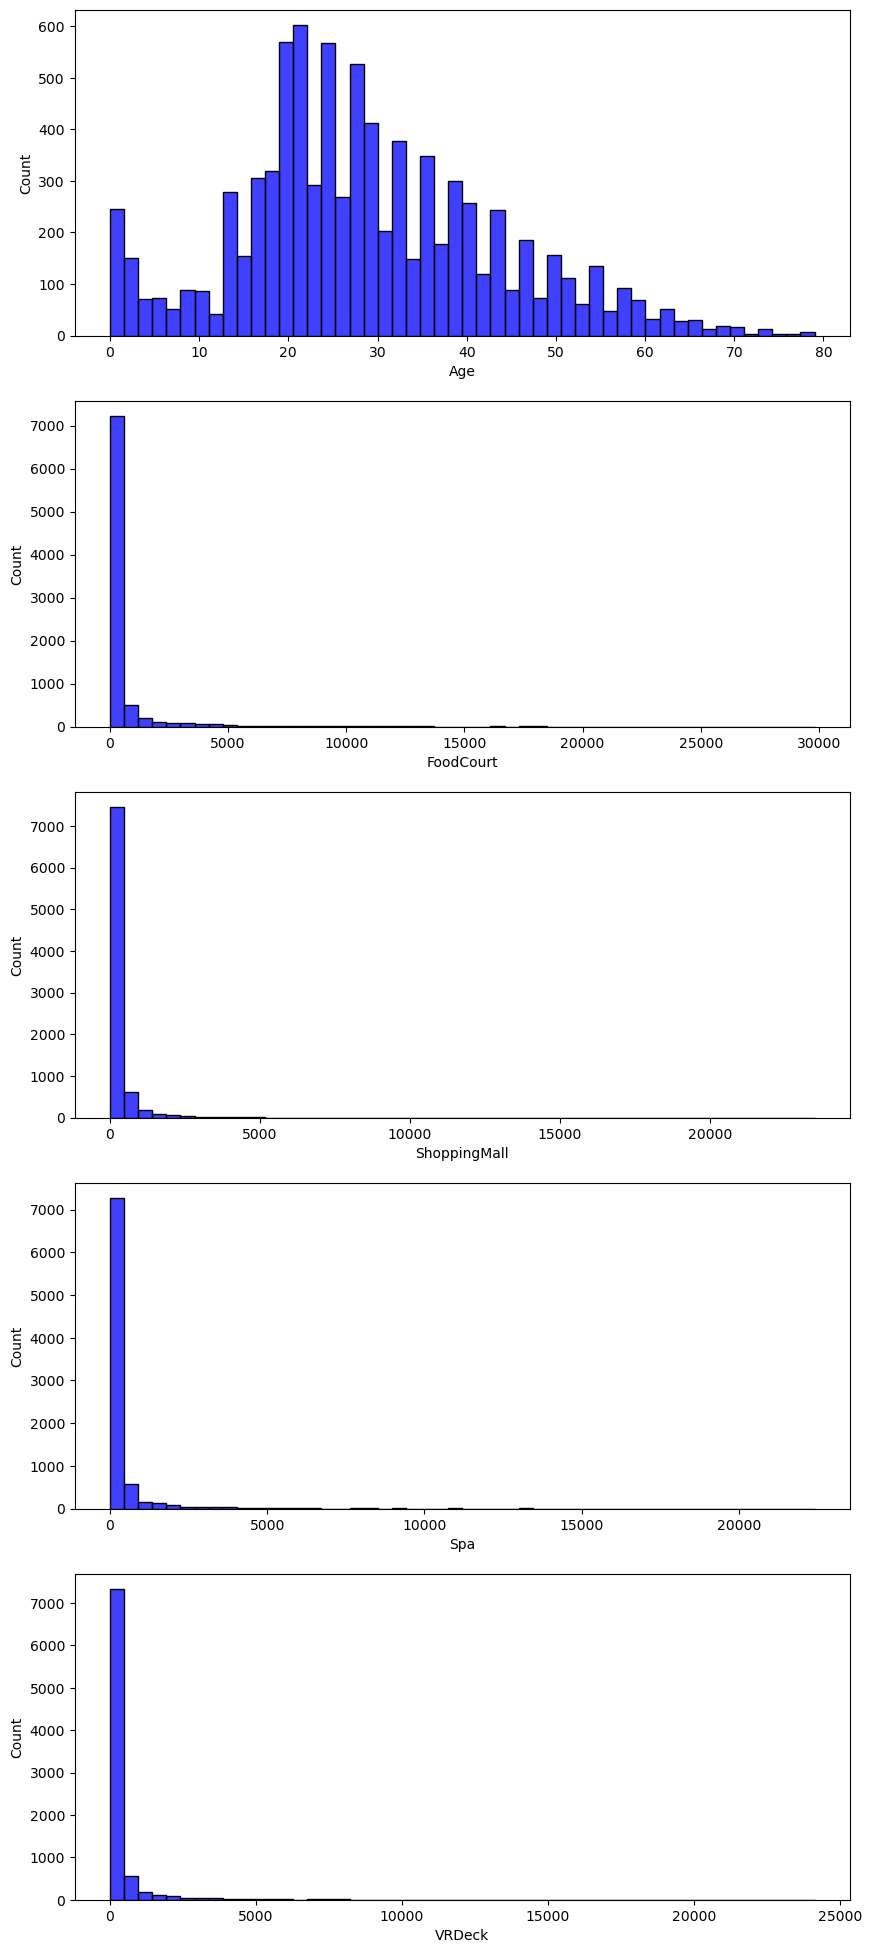

In [4]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(dataset['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(dataset['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(dataset['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(dataset['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(dataset['VRDeck'], color='b', bins=50, ax=ax[4]);

## Data Cleaning

In [5]:
dataset = dataset.drop(['PassengerId', 'Name'], axis=1)
dataset.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [6]:
dataset.isnull().sum().sort_values(ascending=False)
dataset[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = dataset[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
dataset.isnull().sum().sort_values(ascending=False)
dataset['Transported'] = dataset['Transported'].astype(int)
dataset['VIP'] = dataset['VIP'].astype(int)
dataset['CryoSleep'] = dataset['CryoSleep'].astype(int)
dataset[['Deck', 'Cabin_num', 'Side']] = dataset['Cabin'].str.split('/', expand=True)
try:
    dataset = dataset.drop('Cabin', axis=1)
except KeyError:
    print('Field does not exist')
dataset.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,1,S


### Data Splitting (Training & Testing)

In [7]:
def split_dataset(data, test_ratio=0.20):
  test_indices = np.random.rand(len(data)) < test_ratio
  return data[~test_indices], data[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

7022 examples in training, 1671 examples in testing.


## Model Selection, Configuration & Training

In [8]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [9]:
rf = tfdf.keras.RandomForestModel()
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='Transported')
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label='Transported')
rf.fit(x=train_ds)

Use /var/folders/3m/lsy624kn18d_nc0sk8swz2900000gn/T/tmp82tsfjvg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.505000. Found 7022 examples.
Training model...


[INFO 23-12-06 01:42:48.6267 EST kernel.cc:1233] Loading model from path /var/folders/3m/lsy624kn18d_nc0sk8swz2900000gn/T/tmp82tsfjvg/model/ with prefix 04569b53278c4aad


Model trained in 0:00:13.245779
Compiling model...


[INFO 23-12-06 01:42:49.0087 EST decision_forest.cc:660] Model loaded with 300 root(s), 235124 node(s), and 13 input feature(s).
[INFO 23-12-06 01:42:49.0088 EST abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 23-12-06 01:42:49.0088 EST kernel.cc:1061] Use fast generic engine


Model compiled.


## Model Visualization & Evaluation

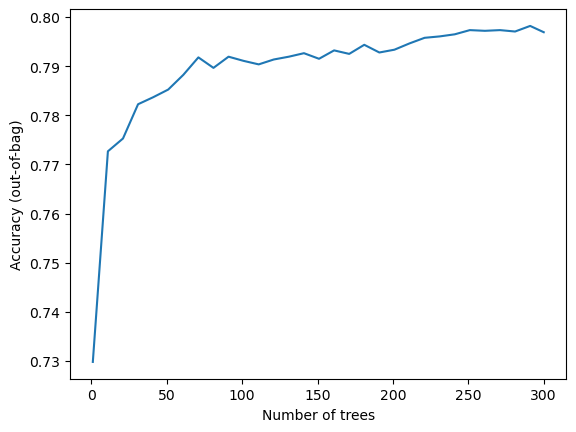

In [10]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()

In [11]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=7022, accuracy=0.796923953289661, loss=0.5233865067939988, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [12]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 0s 41ms/step - loss: 0.0000e+00
loss: 0.0000
